#Evaluation - d14061721

In [11]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [12]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [13]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

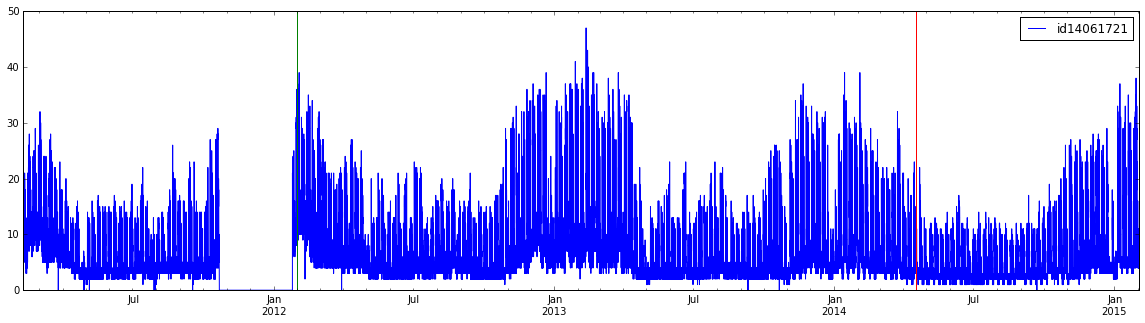

In [14]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [15]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from neural_network import PyBrainNN

## Creating Feature Sets

In [148]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w', 'shifted_DayOfWeek', 'energija_gl_roll_mean_6h', 'measurement_roll_var_6h', 
              't2m_termin_roll_mean_m', 'energija_gl_roll_mean_1h', 'shifted_t2m_termin', 'p_roll_var_d', 
              'measurement_roll_mean_m', 'energija_gl_roll_mean_m', 'energija_gl']

top10_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w']

selected_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_BusinessDay', 'measurement',
                 'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
                 'measurement_roll_mean_w', 'shifted_DayOfWeek', 'measurement_roll_var_6h', 'measurement_roll_mean_m']

In [149]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs
seleceted_ftrs = selected_ftrs

## Prediction Results

In [150]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target
        
    def fit(self, X_train,y_train):
        # No need to fit with naive models
        pass    

In [151]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             {'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             {'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             #{'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             {'name': "SELECTED", 'ftrs': seleceted_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [152]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    sensor_list = ['id14061721']
    #sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id14061721

	-->Prediction horizont: 1h. Shifting runtime: 4.49s

		-->Dataset: Baselines. X_train: (77377L, 16L), y_train: (77377L,)
			-->Computing Last value
				-->R2: 0.800
				-->MAE: 1.181
				-->MAPE: 22.238
				-->MASE: 0.723
			-->Computing Previous day
				-->R2: 0.399
				-->MAE: 2.035
				-->MAPE: 41.432
				-->MASE: 1.246
			-->Computing Previous week
				-->R2: 0.656
				-->MAE: 1.569
				-->MAPE: 30.648
				-->MASE: 0.961
			-->Computing Measurement average
				-->R2: 0.347
				-->MAE: 2.762
				-->MAPE: 67.629
				-->MASE: 1.691

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.02s
				-->R2: 0.863
				-->MAE: 1.116
				-->MAPE: 24.319
				-->MASE: 0.684
			-->Training model: K Nearest Neighbors, runtime: 0.27s
				-->R2: 0.837
				-->MAE: 1.242
				-->MAPE: 28.393
				-->MASE: 0.761
			-->Training model: Random Forest, runtime: 16.58s
				-->R2: 0.877
				-->MAE: 1.100
				-->MAPE: 26.

In [17]:
output_file_name = "validationResults_id14061674.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [142]:
validation_df

sensor                                          id14061721            \
error metric                                            R2       MAE   
horizon dataset             model                                      
1       Last value          Baselines             0.800476  1.181333   
        Previous day        Baselines             0.399198  2.035121   
        Previous week       Baselines             0.655582  1.569490   
        Measurement average Baselines             0.346841  2.761831   
        AR                  Ridge Regression      0.828557  1.237588   
                            K Nearest Neighbors   0.782841  1.435386   
                            Random Forest         0.844032  1.261842   
        SELECTED            Ridge Regression      0.849170  1.245862   
                            K Nearest Neighbors   0.845299  1.226443   
                            Random Forest         0.885265  1.053664   
2       Last value          Baselines             0.568463  1.680168   
        Previous day        Baselines             0.399190  2.035597   
        Previous week       Baselines             0.655598  1.569618   
        Measurement average Baselines             0.188493  3.029163   
        AR                  Ridge Regression      0.672376  1.697692   
                            K Nearest Neighbors   0.571175  1.938762   
                            Random Forest         0.677507  1.892032   
        SELECTED            Ridge Regression      0.745454  1.656427   
                            K Nearest Neighbors   0.773149  1.426715   
                            Random Forest         0.841073  1.205311   

sensor                                                                
error metric                                          MAPE      MASE  
horizon dataset             model                                     
1       Last value          Baselines            22.238089  0.723470  
        Previous day        Baselines            41.431910  1.246346  
        Previous week       Baselines            30.648243  0.961185  
        Measurement average Baselines            67.629211  1.691396  
        AR                  Ridge Regression     26.543414  0.757922  
                            K Nearest Neighbors  33.442628  0.879057  
                            Random Forest        30.392512  0.772775  
        SELECTED            Ridge Regression     29.453845  0.762989  
                            K Nearest Neighbors  27.943199  0.751096  
                            Random Forest        24.358116  0.645283  
2       Last value          Baselines            28.858820  0.723687  
        Previous day        Baselines            41.441275  0.876779  
        Previous week       Baselines            30.649862  0.676071  
        Measurement average Baselines            72.594479  1.304731  
        AR                  Ridge Regression     35.722008  0.731236  
                            K Nearest Neighbors  46.814973  0.835070  
                            Random Forest        49.755672  0.814942  
        SELECTED            Ridge Regression     40.982810  0.713462  
                            K Nearest Neighbors  31.420843  0.614520  
                            Random Forest        26.538190  0.519155

## Averaged Horizons Scores 

In [77]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                                  id14061721                       \
error metric                                    R2       MAE       MAPE   
dataset             model                                                 
Last value          Baselines             0.561509  1.675817  29.038490   
Previous day        Baselines             0.126927  2.620975  50.331238   
Previous week       Baselines             0.383201  2.106507  38.725436   
Measurement average Baselines             0.176525  3.042106  72.821162   
AR                  Ridge Regression      0.679565  1.672887  35.615905   
                    K Nearest Neighbors   0.589254  1.875141  45.090843   
                    Random Forest         0.690614  1.810825  48.090748   
SELECTED            Ridge Regression      0.755056  1.611357  39.967885   
                    K Nearest Neighbors   0.781093  1.401275  30.995457   
                    Random Forest         0.843011  1.197585  26.494455   

sensor                                             
error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            1.178772  
Previous week       Baselines            0.941285  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.733369  
                    K Nearest Neighbors  0.827457  
                    Random Forest        0.789089  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.540092

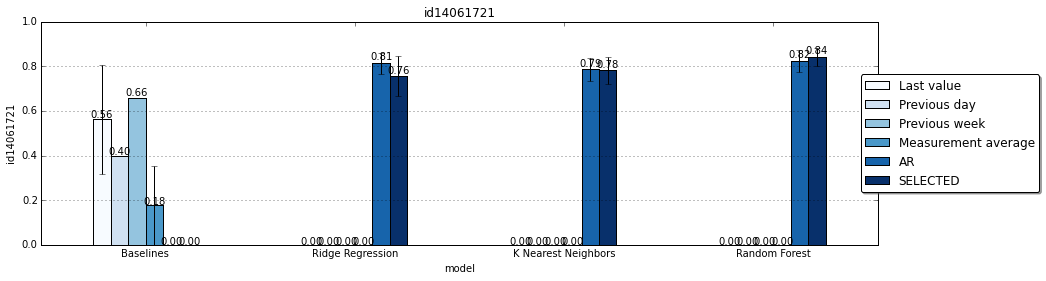

In [154]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(sensor_id)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

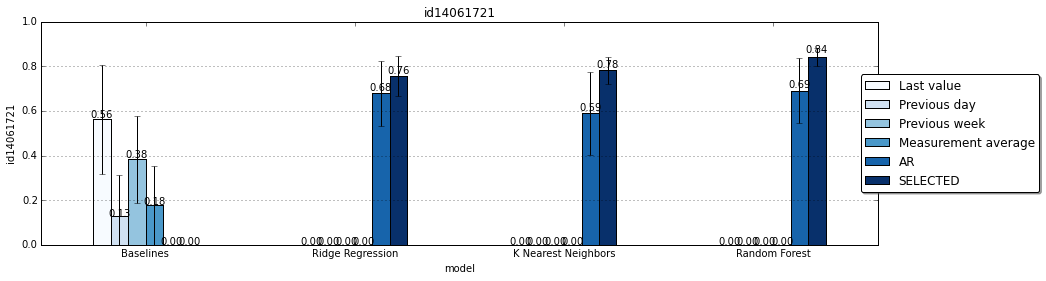

In [78]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(sensor_id)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

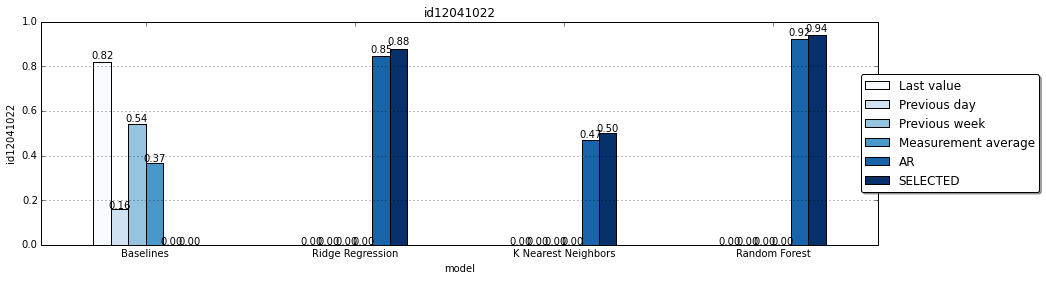

In [50]:
for sensor_id in validation_df.columns.levels[0]:
        
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(sensor_id)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Averaged Scores by Sensors

In [116]:
validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061721']['R2']

dataset,Last value,Previous day,Previous week,Measurement average
horizon,,,,
1,0.800476,0.306844,0.573577,0.346841
2,0.568463,0.135119,0.391422,0.188493
3,0.315588,-0.061181,0.184604,-0.005759


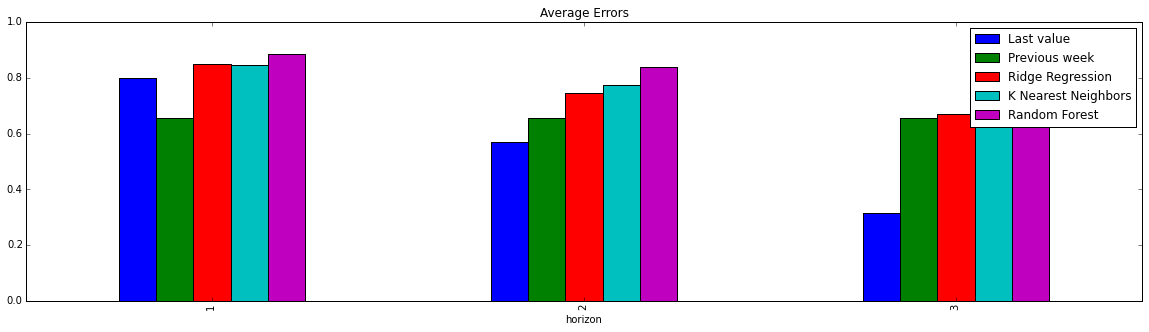

In [155]:
validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061721']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["SELECTED"], level=["dataset"]).unstack()['id14061721']['R2']).plot(
    kind='bar', figsize=(20,5), title="Average Errors", ylim=(0,1))

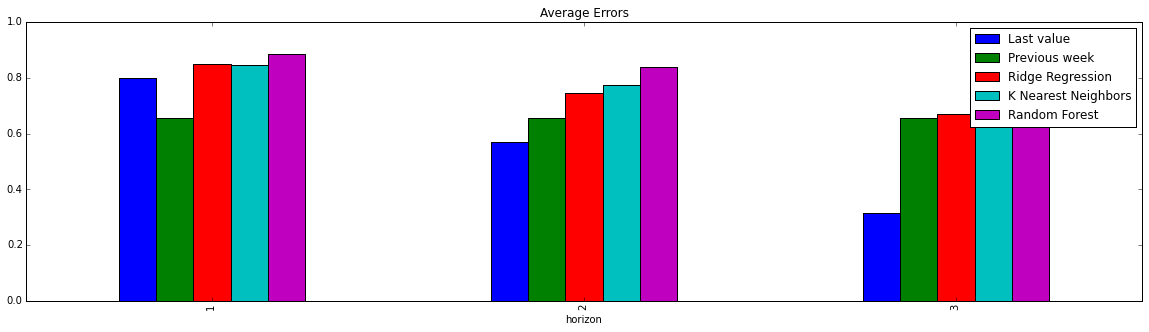

In [147]:
validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061721']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["SELECTED"], level=["dataset"]).unstack()['id14061721']['R2']).plot(
    kind='bar', figsize=(20,5), title="Average Errors", ylim=(0,1))

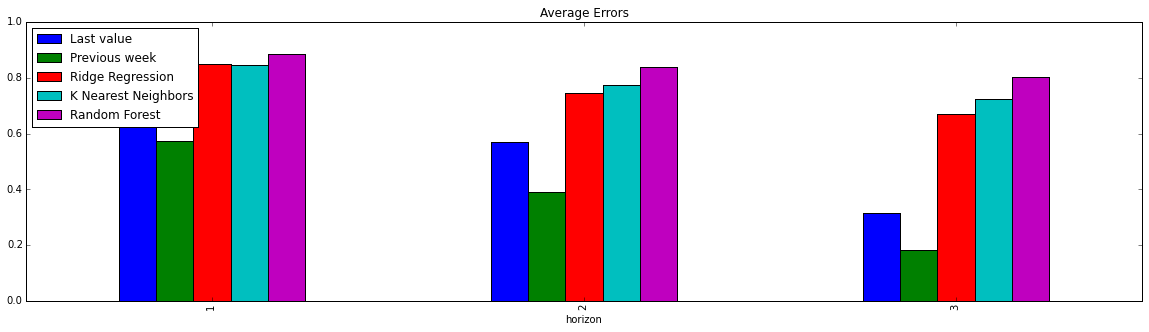

In [138]:
validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061721']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["SELECTED"], level=["dataset"]).unstack()['id14061721']['R2']).plot(
    kind='bar', figsize=(20,5), title="Average Errors", ylim=(0,1))

### Error plot for different prediction horizons and averaged errors by sensors

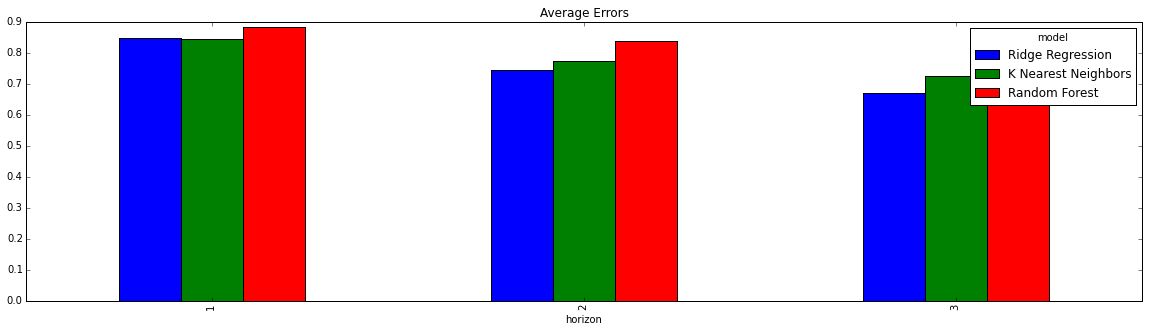

In [96]:
ax = validation_df.xs(["SELECTED"], level=["dataset"]).unstack()['id14061721']['R2'].plot(
    kind='bar', figsize=(20,5), title="Average Errors")

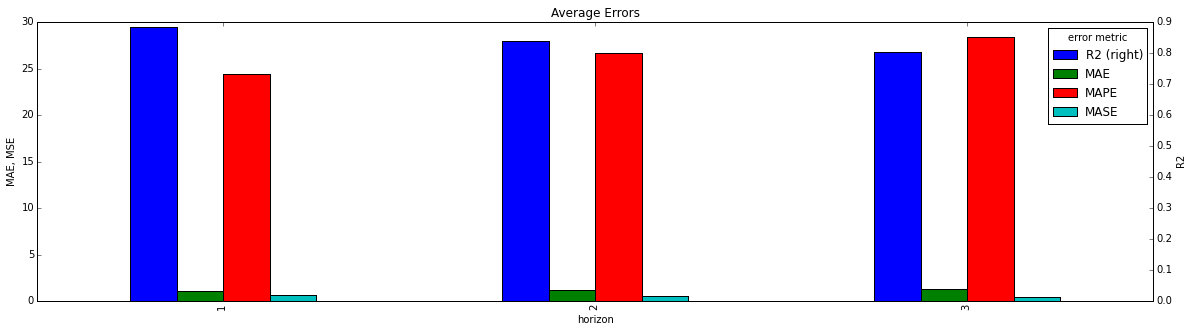

In [80]:
ax = validation_df.xs(("SELECTED", "Random Forest"), level=["dataset", "model"]).groupby(
    level='error metric', axis=1).mean().plot(kind='bar', figsize=(20,5), secondary_y=['R2'], title="Average Errors")
ax.set_ylabel('MAE, MSE')
ax.right_ax.set_ylabel('R2')

## Average Score by Sensors and Horizons

In [70]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                        R2        MAE           MSE
dataset  model                                                 
AR       Ridge Regression     0.462579  52.069420  10600.877892
         K Nearest Neighbors  0.125049  62.786934  18069.799385
         Random Forest        0.482660  39.755100   7113.245927
AR_WC_WF Ridge Regression     0.509606  50.275624   9930.131509
         K Nearest Neighbors -0.116841  68.296435  19796.309909
         Random Forest        0.482886  39.872278   6639.080224
AR_DT    Ridge Regression     0.638006  42.244531   6855.436051
         K Nearest Neighbors  0.115445  63.100004  18176.121847
         Random Forest        0.740797  24.894878   2833.590550
AR_WC_DT Ridge Regression     0.637011  42.195644   6817.984735
         K Nearest Neighbors -0.157980  68.981981  19867.963717
         Random Forest        0.695394  28.514201   3731.043985
AR_WF_DT Ridge Regression     0.638217  42.197730   6820.501427
         K Nearest Neighbors  0.155570  61.698406  17500.033228
         Random Forest        0.729721  25.525282   2999.072624
ALL      Ridge Regression     0.637612  42.150633   6803.777693
         K Nearest Neighbors -0.119643  68.315466  19798.023134
         Random Forest        0.696693  28.646940   3825.389762
TOP_20   Ridge Regression     0.620579  43.248407   7205.101574
         K Nearest Neighbors  0.202324  59.684485  16500.076570
         Random Forest        0.649973  29.498487   4063.528393
TOP_10   Ridge Regression     0.619717  43.506955   7292.699514
         K Nearest Neighbors  0.212902  58.544007  17316.544188
         Random Forest        0.691421  26.595288   3280.997984
SELECTED Ridge Regression     0.622300  43.254238   7233.263663
         K Nearest Neighbors  0.155655  63.215530  18334.489460
         Random Forest        0.701893  26.197264   3251.336471

In [69]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean().unstack()

error metric               R2                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
AR                   0.462579            0.125049      0.482660   
AR_WC_WF             0.509606           -0.116841      0.482886   
AR_DT                0.638006            0.115445      0.740797   
AR_WC_DT             0.637011           -0.157980      0.695394   
AR_WF_DT             0.638217            0.155570      0.729721   
ALL                  0.637612           -0.119643      0.696693   
TOP_20               0.620579            0.202324      0.649973   
TOP_10               0.619717            0.212902      0.691421   
SELECTED             0.622300            0.155655      0.701893   

error metric              MAE                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
AR                  52.069420           62.786934     39.755100   
AR_WC_WF            50.275624           68.296435     39.872278   
AR_DT               42.244531           63.100004     24.894878   
AR_WC_DT            42.195644           68.981981     28.514201   
AR_WF_DT            42.197730           61.698406     25.525282   
ALL                 42.150633           68.315466     28.646940   
TOP_20              43.248407           59.684485     29.498487   
TOP_10              43.506955           58.544007     26.595288   
SELECTED            43.254238           63.215530     26.197264   

error metric              MSE                                    
model        Ridge Regression K Nearest Neighbors Random Forest  
dataset                                                          
AR               10600.877892        18069.799385   7113.245927  
AR_WC_WF          9930.131509        19796.309909   6639.080224  
AR_DT             6855.436051        18176.121847   2833.590550  
AR_WC_DT          6817.984735        19867.963717   3731.043985  
AR_WF_DT          6820.501427        17500.033228   2999.072624  
ALL               6803.777693        19798.023134   3825.389762  
TOP_20            7205.101574        16500.076570   4063.528393  
TOP_10            7292.699514        17316.544188   3280.997984  
SELECTED          7233.263663        18334.489460   3251.336471

In [8]:
#validation_df.loc[1,:, ['Ridge Regression','Random Forest']]

NameError: name 'validation_df' is not defined

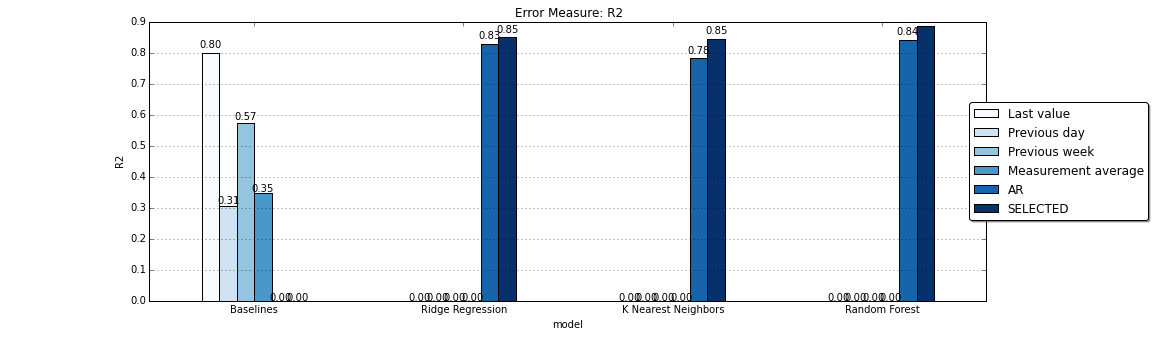

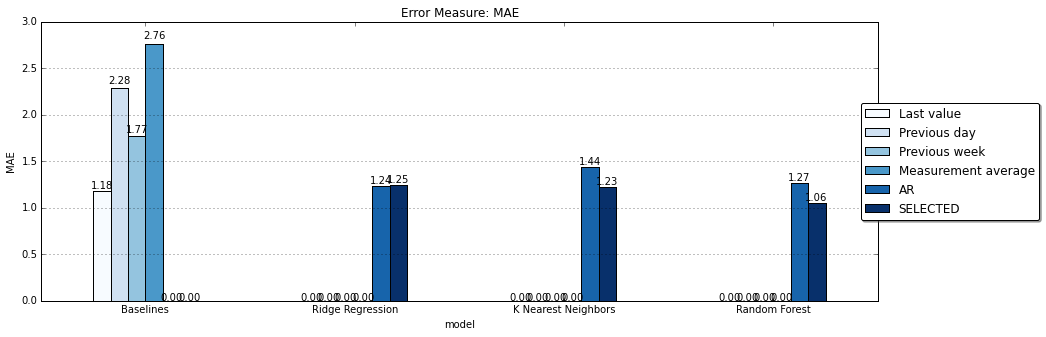

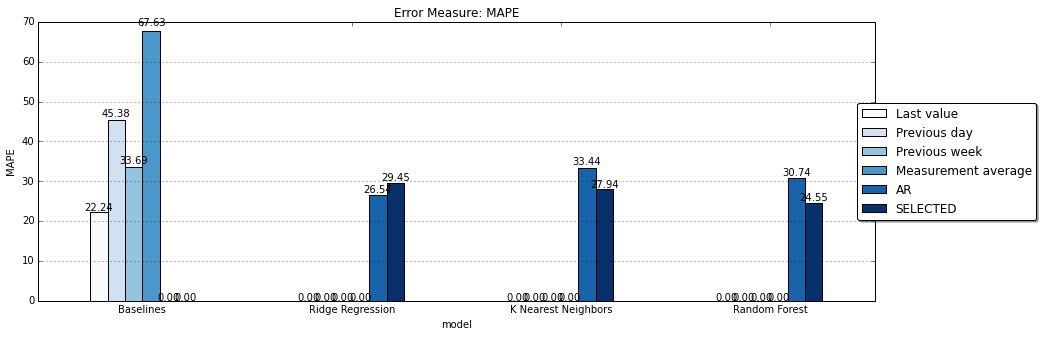

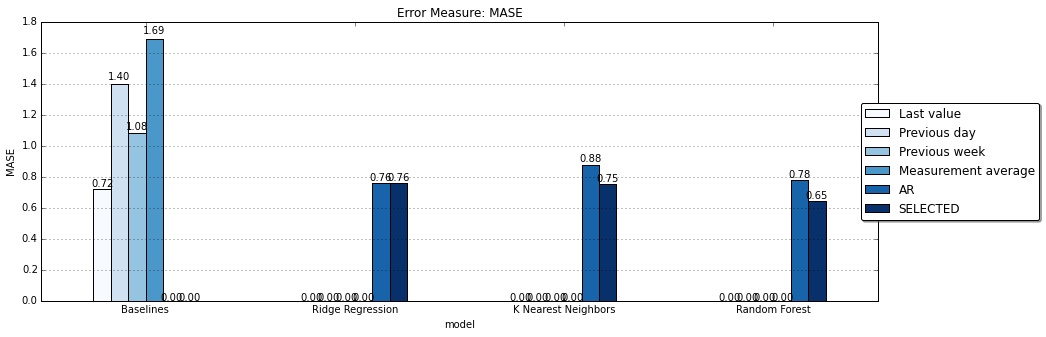

In [53]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.